In [ ]:
import pandas as pd
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import string
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM,GRU
from keras.layers.core import Dense,Activation
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence, text
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.models import load_model,Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense,SimpleRNN,Input,Dropout,Flatten,Concatenate,BatchNormalization,Bidirectional
from tensorflow.keras import regularizers,optimizers
import datetime

In [ ]:
def jaccard(str1,str2): 
    a=set(str1.lower().split()) 
    b=set(str2.lower().split())
    c=a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive//My Drive/Tweet Sentiment Extraction/updated_train.pkl','rb') as f:
     train=pickle.load(f)

with open('/content/drive//My Drive/Tweet Sentiment Extraction/preprocessed_test.pkl','rb') as f:
     test=pickle.load(f)

In [ ]:
train.head()

,textID,text,selected_text,sentiment,spelling,start_index,end_index
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,++++,0,6
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,++++,0,1
2,088c60f138,my boss is bullying me,bullying me,negative,++++,3,4
3,9642c003ef,what interview leave me alone,leave me alone,negative,++++,2,4
4,358bd9e861,sons of ABUSE why couldnt they put them on th...,sons of ABUSE,negative,++++,0,2


In [ ]:
test.head()

,textID,text,sentiment
0,f87dea47db,last session of the day,neutral
1,96d74cb729,shanghai is also really exciting precisely s...,positive
2,eee518ae67,recession hit veronique branquinho she has to ...,negative
3,01082688c6,happy bday,positive
4,33987a8ee5,i like it,positive


In [ ]:
text_split=train['text'].apply(lambda x: len(str(x).split())).tolist()

In [ ]:
max(text_split)

32

* 

We have to predict start and end tokens of a given sentence,so extract the output labels with start and end tokens as 1 and rest as 0.


In [ ]:
#https://www.geeksforgeeks.org/numpy-zeros-python/
y=np.zeros((train.shape[0],max(text_split)+1))
for i in range(train.shape[0]):
  start=train['start_index'][i]
  end=train['end_index'][i]
  y[i][start:end+1]=1

In [ ]:
for i in [1,6,11,22]:
  print(train['start_index'][i],train['end_index'][i])
  print('\n')
  print(train['text'][i])
  print('\n')
  print(train['selected_text'][i])
  print('\n')
  print(y[i])
  print("="*150)

0 1


 sooo sad i will miss you here in san diego


sooo sad


[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 5


  feedings for the baby are fun when he is all smiles and coos


fun


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 3


i really really like the song love story by taylor swift


like


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 11


is cleaning the house for her family who is comming later today


is cleaning the house for her family who is comming later today


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
y.shape

(27381, 33)

In [ ]:
X=train[['textID','text','selected_text','sentiment']]

In [ ]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.15,random_state=42)

In [ ]:
print("X_train shape ",X_train.shape,"  X_test shape ",X_valid.shape)
print("\ny_train shape ",y_train.shape,"  y_test shape ",y_valid.shape)

X_train shape  (23273, 4)   X_test shape  (4108, 4)

y_train shape  (23273, 33)   y_test shape  (4108, 33)


In [ ]:
y_train=np.expand_dims(y_train,-1)
y_valid=np.expand_dims(y_valid,-1)
y_train.shape,y_valid.shape

((23273, 33, 1), (4108, 33, 1))

In [ ]:
train_text=X_train['text'].values
valid_text=X_valid['text'].values
train_sentiment=X_train['sentiment'].values
valid_sentiment=X_valid['sentiment'].values

In [ ]:
# using keras tokenizer here
token1=text.Tokenizer(num_words=None)
max_len_text=32

token1.fit_on_texts(list(train_text))
train_text=token1.texts_to_sequences(train_text)
valid_text=token1.texts_to_sequences(valid_text)


#zero pad the sequences
train_text=sequence.pad_sequences(train_text,maxlen=max_len_text,padding='post')
valid_text=sequence.pad_sequences(valid_text,maxlen=max_len_text,padding='post')

word_index_text=token1.word_index
print(word_index_text)

{'i': 1, 'to': 2, 'the': 3, 'a': 4, 'my': 5, 'and': 6, 'you': 7, 'it': 8, 'is': 9, 'in': 10, 'for': 11, 'of': 12, 'im': 13, 'on': 14, 'me': 15, 'have': 16, 'that': 17, 'so': 18, 'but': 19, 'just': 20, 'with': 21, 'day': 22, 'be': 23, 'its': 24, 'at': 25, 'not': 26, 'was': 27, 'all': 28, 'good': 29, 'this': 30, 'now': 31, 'out': 32, 'up': 33, 'get': 34, 'are': 35, 'like': 36, 'no': 37, 'go': 38, 'dont': 39, 'do': 40, 'your': 41, 'going': 42, 'love': 43, 'too': 44, 'today': 45, 'work': 46, 'got': 47, 'abuse': 48, 'cant': 49, 'one': 50, 'from': 51, 'happy': 52, 'time': 53, 'what': 54, 'know': 55, 'lol': 56, 'u': 57, 'really': 58, 'back': 59, 'will': 60, 'about': 61, 'am': 62, 'had': 63, 'we': 64, 'there': 65, 'see': 66, 'can': 67, 'if': 68, 'some': 69, 'new': 70, 'well': 71, 'night': 72, 'home': 73, 'as': 74, 'want': 75, 'mothers': 76, 'when': 77, 'how': 78, 'more': 79, 'still': 80, 'much': 81, 'think': 82, 'thanks': 83, 'oh': 84, 'off': 85, 'they': 86, 'miss': 87, 'here': 88, 'great': 89

In [ ]:
print(train_text.shape,valid_text.shape)

(23273, 32) (4108, 32)


In [ ]:
# using keras tokenizer here
token2=text.Tokenizer(num_words=None)
max_len_sentiment=1

token2.fit_on_texts(list(train_sentiment))
train_sentiment=token2.texts_to_sequences(train_sentiment)
valid_sentiment=token2.texts_to_sequences(valid_sentiment)


#zero pad the sequences
train_sentiment=sequence.pad_sequences(train_sentiment,maxlen=max_len_sentiment,padding='post')
valid_sentiment=sequence.pad_sequences(valid_sentiment,maxlen=max_len_sentiment,padding='post')

word_index_sentiment=token2.word_index
print(word_index_sentiment)

{'neutral': 1, 'positive': 2, 'negative': 3}


In [ ]:
print(train_sentiment.shape,valid_sentiment.shape)

(23273, 1) (4108, 1)


In [ ]:
# load the GloVe vectors in a dictionary:
embeddings_index = {}
with open('/content/drive//My Drive/Tweet Sentiment Extraction/glove.840B.300d.txt') as f:
  for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

2196018it [04:34, 7994.69it/s]

Found 2196017 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix_text=np.zeros((len(word_index_text) + 1, 300))
for word, i in tqdm(word_index_text.items()):
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_text[i]=embedding_vector

100%|██████████| 23998/23998 [00:00<00:00, 373459.88it/s]


In [ ]:
embedding_matrix_text.shape

(23999, 300)

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix_sentiment=np.zeros((len(word_index_sentiment) + 1, 300))
for word, i in tqdm(word_index_sentiment.items()):
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_sentiment[i]=embedding_vector

100%|██████████| 3/3 [00:00<00:00, 19298.94it/s]


In [ ]:
embedding_matrix_sentiment.shape

(4, 300)

#LSTM 

In [ ]:
text_input=Input(shape=(max_len_text,),name='text_input')
embd_text=Embedding(len(word_index_text)+1, #embedding layer with glove vectors as embeddings
                    300,
                    weights=[embedding_matrix_text],
                    input_length=max_len_text,
                    trainable=False,mask_zero=True,name='embedding_text')(text_input) #masking the input values with mask_zero= True


sentiment_input=Input(shape=(max_len_sentiment,),name='sentiment_input')
embd_sentiment=Embedding(len(word_index_sentiment)+1, #embedding layer with glove vectors as embeddings
                    300,
                    weights=[embedding_matrix_sentiment],
                    input_length=max_len_text,
                    trainable=False,mask_zero=True,name='embedding_sentiment')(sentiment_input) #masking the input values with mask_zero= True



con=Concatenate(axis=1)([embd_text,embd_sentiment])

lstm=LSTM(64,return_sequences=True,kernel_regularizer=regularizers.l2(0.001),name='LSTM')(con) #lstm

#dense layers with drop outs and batch normalisation
m=Dense(32,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(lstm) 
m=Dropout(0.5)(m)
m=BatchNormalization()(m)
m=Dense(4,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(m)
output=Dense(1,activation='sigmoid',name='output')(m)

model=Model(inputs=[text_input,sentiment_input],outputs=[output])

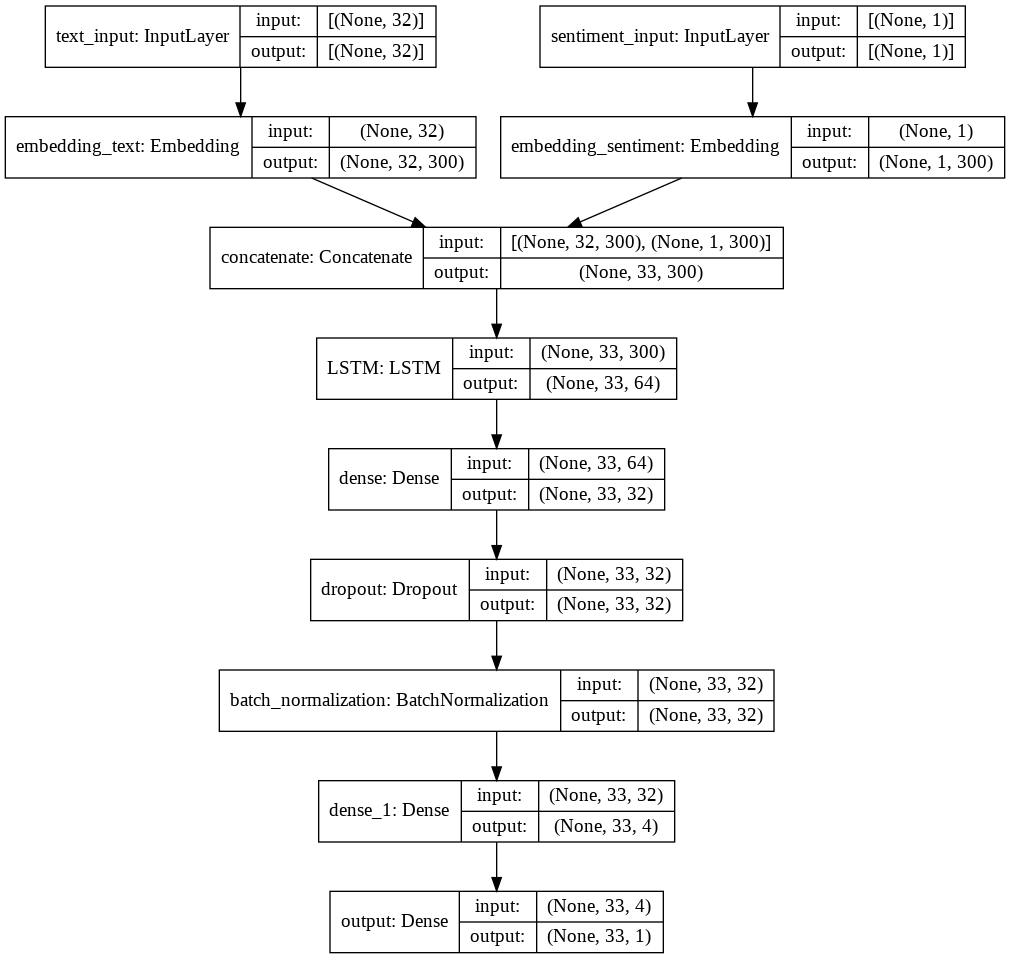

In [ ]:
tf.keras.utils.plot_model(model,'Model.png',show_shapes=True,show_layer_names=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 32)]         0                                            
__________________________________________________________________________________________________
sentiment_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_text (Embedding)      (None, 32, 300)      7199700     text_input[0][0]                 
__________________________________________________________________________________________________
embedding_sentiment (Embedding) (None, 1, 300)       1200        sentiment_input[0][0]            
______________________________________________________________________________________________

In [ ]:
log_dir=os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True,write_grads=True)

checkpoint_filepath='/content/drive//My Drive/Tweet Sentiment Extraction/LSTM_model.h5'
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_loss',save_best_only=True,verbose=1)

#https://keras.io/api/metrics/ 
#https://keras.io/api/losses/probabilistic_losses/#categorical_crossentropy-function

adam=optimizers.Adam(0.001)
model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])
callback=[model_checkpoint_callback,tensorboard]

#https://datascience.stackexchange.com/questions/34444/what-is-the-difference-between-fit-and-fit-generator-in-keras
history=model.fit([train_text,train_sentiment],y_train,epochs=30,batch_size=128,validation_data=([valid_text,valid_sentiment],[y_valid]),verbose=1,
                                                                                                                                    callbacks=callback)

Epoch 1/30
182/182 [==============================] - 29s 136ms/step - loss: 0.3899 - accuracy: 0.5788 - val_loss: 0.2966 - val_accuracy: 0.5926

Epoch 00001: val_loss improved from inf to 0.29656, saving model to /content/drive//My Drive/Tweet Sentiment Extraction/LSTM_model.h5
Epoch 2/30
182/182 [==============================] - 26s 142ms/step - loss: 0.2779 - accuracy: 0.6111 - val_loss: 0.2638 - val_accuracy: 0.5943

Epoch 00002: val_loss improved from 0.29656 to 0.26380, saving model to /content/drive//My Drive/Tweet Sentiment Extraction/LSTM_model.h5
Epoch 3/30
182/182 [==============================] - 27s 151ms/step - loss: 0.2624 - accuracy: 0.6258 - val_loss: 0.2490 - val_accuracy: 0.6356

Epoch 00003: val_loss improved from 0.26380 to 0.24895, saving model to /content/drive//My Drive/Tweet Sentiment Extraction/LSTM_model.h5
Epoch 4/30
182/182 [==============================] - 26s 145ms/step - loss: 0.2576 - accuracy: 0.6310 - val_loss: 0.2443 - val_accuracy: 0.6349

Epoch 

In [ ]:
log_dir=os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True,write_grads=True)

checkpoint_filepath='/content/drive//My Drive/Tweet Sentiment Extraction/LSTM_model.h5'
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_loss',save_best_only=True,verbose=1)

#https://keras.io/api/metrics/ 
#https://keras.io/api/losses/probabilistic_losses/#categorical_crossentropy-function

adam=optimizers.Adam(0.001)
model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])
callback=[model_checkpoint_callback,tensorboard]

#https://datascience.stackexchange.com/questions/34444/what-is-the-difference-between-fit-and-fit-generator-in-keras
history=model.fit([train_text,train_sentiment],y_train,epochs=30,batch_size=128,validation_data=([valid_text,valid_sentiment],[y_valid]),verbose=1,
                                                                                                                                    callbacks=callback)

Epoch 1/30
182/182 [==============================] - 64s 313ms/step - loss: 0.4082 - accuracy: 0.5757 - val_loss: 0.3108 - val_accuracy: 0.5894

Epoch 00001: val_loss improved from inf to 0.31080, saving model to /content/drive//My Drive/Tweet Sentiment Extraction/Model_LSTM.h5
Epoch 2/30
182/182 [==============================] - 55s 301ms/step - loss: 0.2888 - accuracy: 0.6008 - val_loss: 0.2702 - val_accuracy: 0.5904

Epoch 00002: val_loss improved from 0.31080 to 0.27019, saving model to /content/drive//My Drive/Tweet Sentiment Extraction/Model_LSTM.h5
Epoch 3/30
182/182 [==============================] - 55s 300ms/step - loss: 0.2661 - accuracy: 0.6179 - val_loss: 0.2514 - val_accuracy: 0.6167

Epoch 00003: val_loss improved from 0.27019 to 0.25143, saving model to /content/drive//My Drive/Tweet Sentiment Extraction/Model_LSTM.h5
Epoch 4/30
182/182 [==============================] - 56s 305ms/step - loss: 0.2595 - accuracy: 0.6249 - val_loss: 0.2449 - val_accuracy: 0.6331

Epoch 

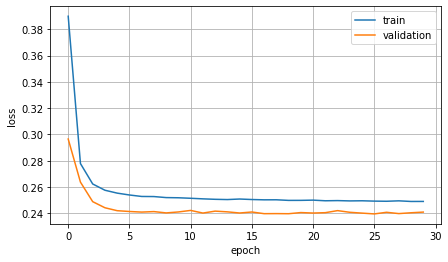

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.grid()
plt.show()

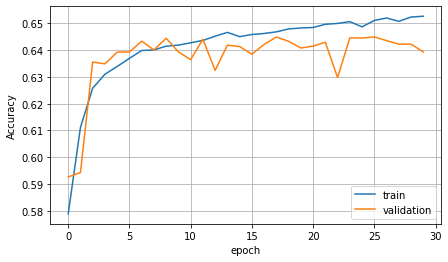

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.grid()
plt.show()

#Training Dataset

In [ ]:
train_pred=model.predict([train_text,train_sentiment])
#https://www.geeksforgeeks.org/numpy-squeeze-in-python/
train_pred=np.squeeze(train_pred)
train_pred=np.round(train_pred)
train_pred.shape

(23273, 33)

In [ ]:
pred=[]
for vector in train_pred:
  index=[]
  for i,value in enumerate(vector):
    if value == 1:
      index.append(i)
  pred.append(np.array(index))
print(len(pred))

23273


In [ ]:
X_train['prediction']=pred
X_train.head(20)

,textID,text,selected_text,sentiment,prediction
8542,97b3fee0c0,work til,work til,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
26493,cadd44e0ed,ok sending me messages asking to set my blog l...,ok sending me messages asking to set my blog l...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
14835,d27e0ab61d,welcoming new followers thanks for the...,thanks for the love,positive,"[3, 6]"
9140,3f1dc607f2,im such a nerd reading my first of many books ...,nerd,negative,"[0, 1, 2, 3, 4]"
22561,fe4e8393d5,is going to see the hannah montana movielolwha...,is going to see the hannah montana movielolwha...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
26245,e0a172bc68,i cut my hand open,i cut my hand open,negative,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2870,0068b3323c,lavish i told diamond to follow you and why u ...,i told diamond to follow you and why u aitn sh...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
19153,62fbde9857,you tell us,you tell us,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
27222,f1142bc75a,ss back to the gym project finally finished A...,filthy,negative,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18,..."
20311,6abf30463f,nah i understand you cant cancel i just wante...,nah i understand you cant cancel i just wanted...,positive,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
def get_text(x):
  pred=[]
  text=x[0]
  index=x[1]
  text=text.split()
  l=len(text)
  for i in index:
    if i < l:
      pred.append(text[i])
  return pred

In [ ]:
pred_text=X_train[['text','prediction']].apply(lambda x: get_text(x),axis=1)
X_train['pred_text']=pred_text
X_train['pred_text']=X_train['pred_text'].apply(lambda x: ' '.join(x))
X_train.head(20)

,textID,text,selected_text,sentiment,prediction,pred_text
8542,97b3fee0c0,work til,work til,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",work til
26493,cadd44e0ed,ok sending me messages asking to set my blog l...,ok sending me messages asking to set my blog l...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",ok sending me messages asking to set my blog l...
14835,d27e0ab61d,welcoming new followers thanks for the...,thanks for the love,positive,"[3, 6]",thanks love
9140,3f1dc607f2,im such a nerd reading my first of many books ...,nerd,negative,"[0, 1, 2, 3, 4]",im such a nerd reading
22561,fe4e8393d5,is going to see the hannah montana movielolwha...,is going to see the hannah montana movielolwha...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",is going to see the hannah montana movielolwha...
26245,e0a172bc68,i cut my hand open,i cut my hand open,negative,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",i cut my hand open
2870,0068b3323c,lavish i told diamond to follow you and why u ...,i told diamond to follow you and why u aitn sh...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",lavish i told diamond to follow you and why u ...
19153,62fbde9857,you tell us,you tell us,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",you tell us
27222,f1142bc75a,ss back to the gym project finally finished A...,filthy,negative,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18,...",ss back to the gym project finally finished AB...
20311,6abf30463f,nah i understand you cant cancel i just wante...,nah i understand you cant cancel i just wanted...,positive,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",nah i understand you cant cancel i just wanted...


In [ ]:
X_train['jaccard']=X_train.apply(lambda x: jaccard(x.selected_text,x.pred_text),axis=1)
print('Mean training Jaccard score:',np.mean(X_train['jaccard']))
print("="*150)
print('nMean jaccard score for positive sentiment tweets:',np.mean(X_train[X_train['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(X_train[X_train['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(X_train[X_train['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.592125170683316
nMean jaccard score for positive sentiment tweets: 0.3731591875971906
Mean jaccard score for negative sentiment tweets 0.37941677777395855
Mean jaccard score for neutral sentiment tweets 0.9077134695258827


#Validation Dataset

In [ ]:
valid_pred=model.predict([valid_text,valid_sentiment])
valid_pred=np.squeeze(valid_pred)
valid_pred=np.round(valid_pred)
valid_pred.shape

(4108, 33)

In [ ]:
pred=[]
for vector in valid_pred:
  index=[]
  for i,value in enumerate(vector):
    if value == 1:
      index.append(i)
  pred.append(np.array(index))
print(len(pred))

4108


In [ ]:
X_valid['prediction']=pred
X_valid.head(20)

,textID,text,selected_text,sentiment,prediction
27149,a3125b3dc1,hes back oh noes have you missed me work has ...,insane,negative,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 19,..."
15026,90944c6528,god opened the clouds and said i hate you josh,i hate you josh,negative,"[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
14192,2d003b7d57,everyone says that,everyone says that,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
20828,0d663acecc,i wonder if i should put a bet on cubs winning...,love,positive,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
5135,3a4ff44f1a,i will do that,i will do that,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3053,0252b13fbe,do u ever answer ur fans on here i wish u wou...,do u ever answer ur fans on here i wish u woul...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
15488,72edbb4f6d,now ive got new frensfrm germanymexico n fra...,now ive got new frensfrm germanymexico n fra...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
20778,9b7a9dfd99,already finished chatting haha,already finished chatting haha,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
24362,30cc3c9612,i gave up following she seems really nice b...,i gave up following she seems really nice bu...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 17, 18, 19, 20, 21, 2..."
17418,fd200545ec,my inner desire is to go to an isle in the mid...,my inner desire is to go to an isle in the mid...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
pred_text=X_valid[['text','prediction']].apply(lambda x:get_text(x),axis=1)
X_valid['pred_text']=pred_text
X_valid['pred_text']=X_valid['pred_text'].apply(lambda x: ' '.join(x))
X_valid.head(20)

,textID,text,selected_text,sentiment,prediction,pred_text
27149,a3125b3dc1,hes back oh noes have you missed me work has ...,insane,negative,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 19,...",hes back oh noes have you missed me work has b...
15026,90944c6528,god opened the clouds and said i hate you josh,i hate you josh,negative,"[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",god opened clouds and said i hate you josh
14192,2d003b7d57,everyone says that,everyone says that,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",everyone says that
20828,0d663acecc,i wonder if i should put a bet on cubs winning...,love,positive,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",i wonder if i should put a bet on cubs winning...
5135,3a4ff44f1a,i will do that,i will do that,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",i will do that
3053,0252b13fbe,do u ever answer ur fans on here i wish u wou...,do u ever answer ur fans on here i wish u woul...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",do u ever answer ur fans on here i wish u woul...
15488,72edbb4f6d,now ive got new frensfrm germanymexico n fra...,now ive got new frensfrm germanymexico n fra...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",now ive got new frensfrm germanymexico n franc...
20778,9b7a9dfd99,already finished chatting haha,already finished chatting haha,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",already finished chatting haha
24362,30cc3c9612,i gave up following she seems really nice b...,i gave up following she seems really nice bu...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 17, 18, 19, 20, 21, 2...",i gave up following she seems really nice got ...
17418,fd200545ec,my inner desire is to go to an isle in the mid...,my inner desire is to go to an isle in the mid...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",my inner desire is to go to an isle in the mid...


In [ ]:
X_valid['jaccard']=X_valid.apply(lambda x: jaccard(x.selected_text,x.pred_text),axis=1)
print('Mean training Jaccard score:',np.mean(X_valid['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(X_valid[X_valid['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(X_valid[X_valid['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(X_valid[X_valid['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.5799558281290238
Mean jaccard score for positive sentiment tweets: 0.3578825085702225
Mean jaccard score for negative sentiment tweets 0.3821199941137671
Mean jaccard score for neutral sentiment tweets 0.8910794650327247


#Submission

In [ ]:
model=load_model('/content/drive//My Drive/Tweet Sentiment Extraction/LSTM_model.h5')

In [ ]:
test_text=test['text'].values
test_sentiment=test['sentiment'].values

In [ ]:
test_text=token1.texts_to_sequences(test_text)
test_text=sequence.pad_sequences(test_text,maxlen=max_len_text,padding='post')

In [ ]:
test_sentiment=token2.texts_to_sequences(test_sentiment)
test_sentiment=sequence.pad_sequences(test_sentiment,maxlen=max_len_sentiment,padding='post')

In [ ]:
test_pred=model.predict([test_text,test_sentiment])
test_pred=np.squeeze(test_pred)
test_pred=np.round(test_pred)
test_pred.shape

(3534, 33)

In [ ]:
pred=[]
for vector in test_pred:
  index=[]
  for i,value in enumerate(vector):
    if value == 1:
      index.append(i)
  pred.append(np.array(index))
print(len(pred))

3534


In [ ]:
def get_text(x):
  pred=[]
  text=x[0]
  index=x[1]
  text=text.split()
  l=len(text)
  for i in index:
    if i < l:
      pred.append(text[i])
  return pred

In [ ]:
test['prediction']=pred
pred_text=test[['text','prediction']].apply(lambda x:get_text(x),axis=1)
test['selected_text']=pred_text
test['selected_text']=test['selected_text'].apply(lambda x: ' '.join(x))

In [ ]:
test.drop(['text','sentiment','prediction'],axis=1,inplace=True)

In [ ]:
test.head()

,textID,selected_text
0,f87dea47db,last session of the day
1,96d74cb729,shanghai is also really skyscrapers
2,eee518ae67,branquinho she has her company such a shame
3,01082688c6,happy bday
4,33987a8ee5,i like it


In [ ]:
test.to_csv("/content/drive//My Drive/Tweet Sentiment Extraction/LSTM_submission.csv",index=False)